In [210]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier, AdaBoostClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import FeatureUnion

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,make_scorer,confusion_matrix,auc
from sklearn.externals import joblib
from operator import itemgetter
from matplotlib import pyplot as plt
import itertools

In [57]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\kiran\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text', 'sample', 'style']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
df=pd.read_csv('train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df = df.set_index('id')
y= df.label
df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
#data prep
df=df.fillna(' ')
df['total']=df['title']+' '+df['author']+' '+df['text']
df.head()

,title,author,text,label,total
id,,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [5]:
import re
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

def processing(df):
    df['processed'] = df['total'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
    
    df['length'] = df['processed'].apply(lambda x: len(x))
    
    df['words'] = df['processed'].apply(lambda x: len(x.split(' ')))
    df['words_not_stopword'] = df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
    
    df['avg_word_length'] = df['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
    
    df['commas'] = df['text'].apply(lambda x: x.count(','))

    return(df)

df = processing(df)

In [6]:
features= [c for c in df.columns.values if c  not in ['id','title','author','text','label','total']]
target = 'label'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.33, random_state=42)
X_train.head()

,processed,length,words,words_not_stopword,avg_word_length,commas
id,,,,,,
10567,election 2016 interview with washington jeffer...,14349,2480,1509,5.972830,196
12248,comment on if hillary clinton is charged with ...,7280,1281,708,6.105932,70
7621,i declare myself a conscientious objector craz...,1321,247,123,6.048780,7
8327,the airbnb community commitment henry wolff ai...,1385,240,135,6.385185,20
19239,cartoon of the day what lurks in the swamp tru...,604,98,66,6.348485,5


In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [8]:
text = Pipeline([
                ('selector', TextSelector(key='processed')),
                ('tfidf', TfidfVectorizer( stop_words='english'))
            ])

length =  Pipeline([
                ('selector', NumberSelector(key='length')),
                ('standard', Normalizer())
            ])

words =  Pipeline([
                ('selector', NumberSelector(key='words')),
                ('standard', Normalizer())
            ])

words_not_stopword =  Pipeline([
                ('selector', NumberSelector(key='words_not_stopword')),
                ('standard', Normalizer())
            ])

avg_word_length =  Pipeline([
                ('selector', NumberSelector(key='avg_word_length')),
                ('standard', Normalizer())
            ])

commas =  Pipeline([
                ('selector', NumberSelector(key='commas')),
                ('standard', Normalizer()),
            ])
feats = FeatureUnion([('text', text), 
                      ('length', length),
                      ('words', words),
                      ('words_not_stopword', words_not_stopword),
                      ('avg_word_length', avg_word_length),
                      ('commas', commas)])

feature_processing = Pipeline([('feats', feats)])

In [220]:
rfc_pp = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

rfc_pp.fit(X_train, y_train)
rfc_pp.score(X_test,y_test)

0.8637820512820513

In [221]:
etc_pp = Pipeline([
    ('features',feats),
    ('classifier', ExtraTreesClassifier(n_estimators=5,n_jobs=4)),
])

etc_pp.fit(X_train, y_train)
etc_pp.score(X_test,y_test)

0.8559149184149184

In [222]:
abc_pp = Pipeline([
    ('features',feats),
    ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)),
])

abc_pp.fit(X_train, y_train)
abc_pp.score(X_test,y_test)

0.9548368298368298

In [223]:
mnb_pp = Pipeline([
    ('features',feats),
    ('classifier', MultinomialNB()),
])

mnb_pp.fit(X_train, y_train)
mnb_pp.score(X_test,y_test)

0.8015734265734266

In [224]:
lr_pp = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C=1e5)),
])

lr_pp.fit(X_train, y_train)
lr_pp.score(X_test,y_test)

0.9771270396270396

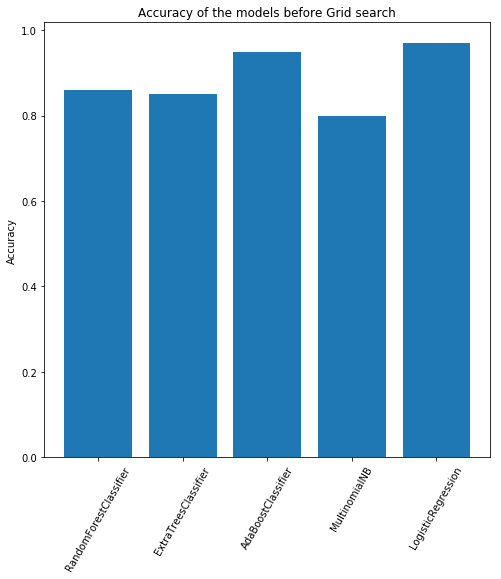

In [257]:
grid_dict = {0: 'RandomForestClassifier', 1: 'ExtraTreesClassifier', 
        2: 'AdaBoostClassifier', 3: 'MultinomialNB', 
        4: 'LogisticRegression'}

objects = ('RandomForestClassifier', 'ExtraTreesClassifier', 'AdaBoostClassifier', 'MultinomialNB', 'LogisticRegression')
y_pos = np.arange(len(objects))
performance = [0.86,0.85,0.95,0.80,0.97]
plt.rcParams['figure.figsize']=[8,8] 
plt.bar(y_pos, performance, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.xticks(rotation=60)
plt.ylabel('Accuracy')
plt.title('Accuracy of the models before Grid search')
 
plt.show()

In [18]:
params_rfc = { 'features__text__tfidf__max_df': [0.8,0.9, 0.95],
                    'features__text__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
              'features__text__tfidf__use_idf': (True, False),
                   'classifier__max_depth': [50, 60, 70],
                    'classifier__min_samples_leaf': [1,2,3]
                  }
params_etc = { 'features__text__tfidf__max_df': [0.8,0.9, 0.95],
                    'features__text__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
              'features__text__tfidf__use_idf': (True, False),
                   'classifier__max_depth': [50, 60, 70],
                    'classifier__min_samples_leaf': [1,2,3]
                  }

params_abc = { 'features__text__tfidf__max_df': [0.8,0.9, 0.95],
                    'features__text__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
              'features__text__tfidf__use_idf': (True, False),
                   'classifier__learning_rate': [0.3, 0.6, 0.9],
                    'classifier__random_state': [21,42,121],
              'classifier__n_estimators': [5,10,15]
                  }
params_mnb = { 'features__text__tfidf__max_df': [0.8,0.9, 0.95],
                    'features__text__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
              'features__text__tfidf__use_idf': (True, False),
                   'classifier__alpha': [0.3, 0.6, 0.9]
                  }

params_lr= {'features__text__tfidf__max_df': [0.8,0.9, 0.95],
            'features__text__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
            'features__text__tfidf__use_idf': (True, False),
            'classifier__C':[1.0,2.5,3.9],
            'classifier__random_state': [21,42,121]
            }

rfc_gs = GridSearchCV(rfc_pp, params_rfc, verbose=3, scoring='accuracy',cv=5)
etc_gs = GridSearchCV(etc_pp, params_etc, verbose=3, scoring='accuracy',cv=5)
abc_gs = GridSearchCV(abc_pp, params_abc, verbose=3, scoring='accuracy',cv=5)
mnb_gs = GridSearchCV(mnb_pp, params_mnb, verbose=3, scoring='accuracy',cv=5)
lr_gs = GridSearchCV(lr_pp, params_lr, verbose=3, scoring='accuracy',cv=5)

In [19]:
# List of pipelines for ease of iteration
grids = [rfc_gs, etc_gs, abc_gs, mnb_gs, lr_gs]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'RandomForestClassifier', 1: 'ExtraTreesClassifier', 
        2: 'AdaBoostClassifier', 3: 'MultinomialNB', 
        4: 'LogisticRegression'}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])	
    # Fit grid search	
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: RandomForestClassifier
Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.859038737446198, total=   9.9s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s


[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8769727403156384, total=  10.8s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.1s remaining:    0.0s


[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.860832137733142, total=  11.5s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8528356066044508, total=  10.7s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8668341708542714, to

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8312993539124193, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8295046661880833, total= 1.2min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8177905308464849,

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8715003589375449, total=  39.4s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8500717360114778, total=  36.7s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.846126255380200

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8576040172166427, total=   9.8s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8769727403156384, total=   9.7s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.867647058

[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8432568149210904, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8375179340028694, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8626255380200861, total=  33.9s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8277099784637473, total=  34.0s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.85032304379038

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.864321608040201, total=   9.2s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8707824838478104, total=   9.1s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.849713055954089, 

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8298636037329504, total=  58.3s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8683644189383071, total=   9.3s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.87948350071736

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8375179340028694, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8274748923959828, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.85796269727403

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.849713055954089, total=  33.8s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8694404591104734, total=  33.6s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8366834170854272, to

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8719512195121951, total=   8.8s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.875448671931084, total=   8.9s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8840631730078966, to

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.832735104091888, total= 1.0min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8330940416367552, total= 1.0min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8213773314203731, 

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8610911701363962, total=  33.9s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8421807747489239, total=  30.5s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8489956958

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8611908177905309, total=  10.2s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8654949784791965, total=  10.0s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.86441893830703

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8446915351506457, total= 1.1min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8443328550932568, total= 1.1min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.84206748025843

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8651362984218077, total=  38.2s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8295046661880833, total=  39.5s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.85893754486719

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8589375448671931, total=  10.0s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.871859296482412, total=  10.1s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.832137733142

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8445800430725053, total= 1.1min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8694404591104734, total=  10.0s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.883428981348637, 

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8407460545193687, total= 1.1min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8432568149210904, total= 1.1min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.870157819225251, to

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8554519368723099, total=  36.2s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8712338593974175, total=  36.1s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8456568557071069, t

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8687230989956959, total=   9.9s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8600143575017947, total=  11.0s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.88478104809763

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8388370423546303, total= 1.1min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8474515434314429, total= 1.1min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.845408895265

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8768844221105527, total=  34.1s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8518651362984218, total=  31.3s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.854734576757532

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8712338593974175, total=   8.9s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8823529411764706, total=   8.8s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.86692969870875

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8489956958393113, total=  57.2s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8385939741750359, total=  57.0s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.85319454414931

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8586800573888091, total=  30.9s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8302225412778177, total=  31.1s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.858578607

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8488872936109118, total=  10.4s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8743718592964824, total=  10.3s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8525824964131994

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8467336683417085, total= 1.2min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.870157819225251, total=  10.4s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8737446197991392, t

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8475609756097561, total= 1.3min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8461262553802008, total= 1.3min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.860832137733142, to

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.853299856527977, total=  45.2s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8672883787661406, total=  45.5s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.866116295764537

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8730272596843616, total=   9.5s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8668341708542714, total=   9.5s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8793969849246231, t

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8531945441493181, total= 1.1min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8388370423546303, total= 1.1min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8389526542324247,

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8826274228284279, total=  36.3s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8579626972740315, total=  33.5s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.851506456241033

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8776901004304161, total=   9.4s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8848637015781923, total=   9.3s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.888809182

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8529411764705882, total= 1.0min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8511477761836442, total= 1.0min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.853194544

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.874103299856528, total=  31.2s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8356066044508256, total=  31.5s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.859655419956927

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8729361091170137, total=  19.9s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.881191672648959, total=  19.7s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8332137733142038,

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8467336683417085, total= 1.2min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8923959827833573, total=  10.7s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.89598278335724

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8400286944045912, total= 1.3min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8411047345767575, total= 1.2min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.86621233859397

[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed: 690.4min finished


Best params: {'classifier__max_depth': 70, 'classifier__min_samples_leaf': 3, 'features__text__tfidf__max_df': 0.8, 'features__text__tfidf__ngram_range': (1, 1), 'features__text__tfidf__use_idf': True}
Best training accuracy: 0.886
Test set accuracy score for best params: 0.885 

Estimator: ExtraTreesClassifier
Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.7783357245337159, total=   9.7s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.5s remaining:    0.0s


[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.7840746054519369, total=   9.0s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.0s remaining:    0.0s


[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.7840746054519369, total=   8.9s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.7821249102656138, total=   8.9s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.825197415649677, to

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.7595118449389806, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.7885857860732233, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.7564562410329986,

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.7882268485283561, total=  36.5s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.7722381635581061, total=  32.7s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.785150645624103

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.7955523672883787, total=   8.9s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.7919655667144907, total=   8.9s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.795193687

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.753586800573888, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.7625538020086083, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.7677674084

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.7890961262553802, total=  32.5s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.7541277817659727, total=  32.4s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.78463747307968

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8198133524766691, total=   9.3s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8072505384063173, total=   9.2s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.7873027259684362

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8033022254127782, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8002152080344332, total=   9.3s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.80954088952654

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.7672166427546628, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.7930416068866571, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.77259684361549

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.7962697274031564, total=  35.3s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.7941176470588235, total=  34.9s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8212491026561378, t

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.7865853658536586, total=   9.2s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8101220387652548, total=   9.4s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.7857142857142857, t

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8047379755922469, total= 1.1min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.7903804737975593, total= 1.2min
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.7525107604017217,

[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.7681263460157932, total=  36.4s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.7890961262553802, total=  31.7s
[CV] classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=50, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8360832137

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.7930416068866571, total=   9.1s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.7862266857962698, total=   8.8s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.80559540889526

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8163558106169297, total= 1.1min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8220946915351507, total= 1.1min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.78750897343862

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.796987087517934, total=  32.9s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.7770997846374731, total=  31.9s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.775305096913137

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.7946877243359656, total=  16.6s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8140703517587939, total=  17.2s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.79160688665

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.7774587221823402, total= 1.6min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.7822812051649928, total=  17.0s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8163558106169297,

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.7765423242467718, total= 1.7min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.7898134863701578, total= 1.7min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8106169296987088, t

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.7937589670014347, total=  51.3s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.7959110473457676, total=  50.6s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8097631012203876, t

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.7991391678622669, total=  14.9s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8022254127781766, total=  14.6s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.80976310122038

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8033022254127782, total= 1.5min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.7799712849964107, total= 1.5min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.774390243902

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.7803302225412778, total=  50.1s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.7905308464849354, total=  45.6s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.783357245337159

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8238880918220947, total=  15.8s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8012912482065997, total=  17.1s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.81599713055954

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.772596843615495, total= 1.7min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.7973457675753228, total= 1.7min
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.767767408470926

[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8285509325681492, total=  45.7s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.7677674084709261, total=  56.1s
[CV] classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=60, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.791816223

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8022254127781766, total=   9.4s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.7957645369705671, total=   9.5s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8070301291248206

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8036611629576453, total= 1.1min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8048780487804879, total=   8.9s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8052367288378766, 

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8030846484935438, total=  59.3s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8260401721664276, total=  59.2s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.7862266857962698, t

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.7908895265423243, total=  32.6s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8066714490674318, total=  33.2s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=1, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.79827709978463

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8188665710186513, total=   8.1s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8198133524766691, total=   8.1s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8244795405599425, t

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.7997128499641063, total=  58.4s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.7889447236180904, total=  58.0s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8002152080344332,

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8330940416367552, total=  31.0s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8203012912482066, total=  28.0s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.801291248206599

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8274748923959828, total=   8.7s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8167144906743186, total=   8.7s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.806312769

[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.7804878048780488, total= 1.0min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.806312769010043, total= 1.0min
[CV] classifier__max_depth=70, classifier__min_samples_leaf=2, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__m

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8088235294117647, total=  34.6s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.7853553481694185, total=  33.6s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.79863603732950

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.7986360373295046, total=   7.7s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8169418521177315, total=   7.8s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8127690100430416

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8255563531945441, total=  53.2s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8081061692969871, total=   8.0s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.80559540889526

[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8020086083213773, total=  58.3s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8052367288378766, total=  58.3s
[CV] classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__max_depth=70, classifier__min_samples_leaf=3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.80882352941176

[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed: 748.7min finished


Best params: {'classifier__max_depth': 60, 'classifier__min_samples_leaf': 3, 'features__text__tfidf__max_df': 0.9, 'features__text__tfidf__ngram_range': (1, 1), 'features__text__tfidf__use_idf': True}
Best training accuracy: 0.823
Test set accuracy score for best params: 0.795 

Estimator: AdaBoostClassifier
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9476327116212339, total=  13.2s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.9s remaining:    0.0s


[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9261119081779053, total=  13.1s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.8s remaining:    0.0s


[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9422525107604017, total=  13.2s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9335965541995693, total=  13.1s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9569583931133429, total= 2.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9465566714490674, total= 2.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9361091170136396, total=  13.0s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9483129935391242, total=  13.0s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.943687230989957, total= 2.4min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9440459110473458, total= 2.4min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.951543431442929, total= 1.2min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9591104734576757, total= 1.1min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__ran

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9426111908177905, total=  13.1s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9335965541995693, total=  13.2s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9569583931133429, total= 2.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9469153515064562, total= 2.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9361091170136396, total=  12.9s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9483129935391242, total=  13.0s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9440459110473458, total= 2.4min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9440459110473458, total= 2.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.951543431442929, total= 1.2min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9591104734576757, total= 1.1min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__ran

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9426111908177905, total=  13.2s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9335965541995693, total=  13.2s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9569583931133429, total= 2.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9469153515064562, total= 2.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9361091170136396, total=  13.1s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9483129935391242, total=  13.0s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__ra

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9440459110473458, total= 2.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9440459110473458, total= 2.4min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__r

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.951543431442929, total= 1.2min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9591104734576757, total= 1.2min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=5, classifier_

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9508608321377331, total=  18.7s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9483129935391242, total=  18.5s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__rand

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9702295552367288, total= 4.0min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9641319942611191, total= 4.0min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__rand

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.949748743718593, total=  18.5s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9615936826992103, total=  18.6s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__ra

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.962338593974175, total= 3.9min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9583931133428981, total= 3.8min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__r

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9705671213208902, total= 1.9min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9677187948350072, total= 1.8min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifie

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9515781922525107, total=  17.9s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.947954055994257, total=  17.8s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__rando

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.96987087517934, total= 4.0min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9641319942611191, total= 3.9min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.949748743718593, total=  37.2s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9619526202440776, total=  37.3s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__ra

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9626972740315638, total= 6.7min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9583931133428981, total= 6.7min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9705671213208902, total= 3.3min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9673601147776184, total= 3.2min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifie

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9515781922525107, total=  32.4s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.947954055994257, total=  34.1s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__r

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9702295552367288, total= 4.0min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9641319942611191, total= 4.3min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.949748743718593, total=  32.4s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9619526202440776, total=  32.5s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9626972740315638, total= 5.8min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9583931133428981, total= 4.1min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifi

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9705671213208902, total= 1.9min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9677187948350072, total= 1.9min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=10, class

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9580344332855093, total=  24.9s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9583632447954056, total=  25.0s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__rand

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9759684361549498, total= 5.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9677187948350072, total= 5.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__rand

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9562096195262024, total=  24.8s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9680545585068198, total=  26.8s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__r

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9687948350071736, total= 6.0min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9644906743185079, total= 5.6min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9705671213208902, total= 2.7min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9745337159253945, total= 2.6min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifie

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9591104734576757, total=  24.9s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9580043072505384, total=  24.9s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__rand

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9777618364418939, total= 5.6min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9677187948350072, total= 5.6min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__rand

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9558506819813353, total=  24.7s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9687724335965542, total=  24.8s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__r

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9691535150645624, total= 5.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9641319942611191, total= 5.4min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9705671213208902, total= 2.6min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9741750358680057, total= 2.6min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifie

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9591104734576757, total=  26.6s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9583632447954056, total=  25.4s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.975609756097561, total= 5.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9677187948350072, total= 5.6min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__r

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9558506819813353, total=  47.8s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.968413496051687, total=  47.8s
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9687948350071736, total= 5.7min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9648493543758967, total= 5.7min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifi

[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9705671213208902, total= 2.7min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9745337159253945, total= 2.5min
[CV] classifier__learning_rate=0.3, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.3, classifier__n_estimators=15, class

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9469153515064562, total=  14.1s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9368269921033741, total=  14.1s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9659253945480631, total= 2.5min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9630559540889526, total= 2.6min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9447236180904522, total=  13.6s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9547738693467337, total=  13.5s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9641319942611191, total= 2.6min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9558823529411765, total= 3.1min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.960875807609476, total= 1.4min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.96987087517934, total= 1.4min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9469153515064562, total=  14.7s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9371859296482412, total=  14.2s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9659253945480631, total= 2.8min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9634146341463414, total= 2.7min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9447236180904522, total=  14.6s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9547738693467337, total=  14.7s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9641319942611191, total= 2.8min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9558823529411765, total= 2.9min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.960875807609476, total= 1.3min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.96987087517934, total= 1.3min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9469153515064562, total=  14.4s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9371859296482412, total=  14.2s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9659253945480631, total= 3.7min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9630559540889526, total= 4.5min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9447236180904522, total=  28.2s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9547738693467337, total=  28.1s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__ra

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9641319942611191, total= 4.4min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9558823529411765, total= 4.3min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__r

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9605168700646087, total= 2.0min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.96987087517934, total= 1.3min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=5, classifier__

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9587517934002869, total=  22.0s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9526202440775305, total=  20.6s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__rand

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9705882352941176, total= 4.1min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9670014347202296, total= 4.1min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__rand

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9558506819813353, total=  20.1s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9651830581478823, total=  20.1s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__r

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9687948350071736, total= 4.1min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9670014347202296, total= 4.0min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9727207465900933, total= 2.2min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9723816355810617, total= 2.2min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifie

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9587517934002869, total=  20.1s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9529791816223977, total=  19.9s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__rand

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9713055954088953, total= 4.1min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9670014347202296, total= 4.1min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__rand

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9558506819813353, total=  19.8s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9641062455132807, total=  19.8s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__r

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9691535150645624, total= 4.0min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9670014347202296, total= 4.1min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9727207465900933, total= 1.9min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9720229555236729, total= 1.9min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifie

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9591104734576757, total=  20.9s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9529791816223977, total=  20.8s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9705882352941176, total= 4.0min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9670014347202296, total= 4.1min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9558506819813353, total=  19.7s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9651830581478823, total=  19.7s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifie

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9684361549497847, total= 4.0min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9670014347202296, total= 4.0min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifi

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9723618090452262, total= 1.9min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9723816355810617, total= 1.9min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=10, class

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9594691535150646, total=  25.9s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9659009332376166, total=  25.6s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__rand

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9716642754662841, total= 5.5min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9734576757532282, total= 5.7min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__rand

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9623115577889447, total=  25.5s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9676956209619526, total=  25.4s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__r

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9720229555236729, total= 5.5min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9705882352941176, total= 6.2min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9734386216798278, total= 2.7min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.975609756097561, total= 2.8min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9594691535150646, total=  26.1s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9662598707824839, total=  25.8s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__rand

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9723816355810617, total= 5.7min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9734576757532282, total= 5.6min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__rand

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9623115577889447, total=  28.3s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.966618808327351, total=  26.0s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__ra

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9723816355810617, total= 8.5min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9705882352941176, total= 8.2min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9734386216798278, total= 4.1min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9752510760401721, total= 4.2min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifie

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9609038737446198, total=  27.0s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9662598707824839, total=  26.1s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9716642754662841, total= 5.6min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9734576757532282, total= 5.7min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9626704953338119, total=  26.3s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9676956209619526, total=  26.1s
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifie

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9716642754662841, total= 5.5min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9705882352941176, total= 5.5min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifi

[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9730796841349605, total= 2.6min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9763271162123386, total= 2.6min
[CV] classifier__learning_rate=0.6, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.6, classifier__n_estimators=15, class

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9483500717360115, total=  15.0s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9458004307250538, total=  14.9s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9670014347202296, total= 2.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9558823529411765, total= 2.7min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.949748743718593, total=  14.1s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9601579325197416, total=  14.0s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9594691535150646, total= 2.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9587517934002869, total= 2.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.968413496051687, total= 1.2min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9655667144906743, total= 1.2min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__ran

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9483500717360115, total=  14.3s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9458004307250538, total=  14.4s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9670014347202296, total= 2.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9558823529411765, total= 2.7min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_st

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.949748743718593, total=  14.1s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9601579325197416, total=  14.1s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9594691535150646, total= 2.6min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9587517934002869, total= 2.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.968413496051687, total= 1.3min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9659253945480631, total= 1.2min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__ran

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9483500717360115, total=  14.3s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9458004307250538, total=  14.3s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9670014347202296, total= 2.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9558823529411765, total= 2.6min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__rando

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.949748743718593, total=  14.2s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9601579325197416, total=  14.1s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__ran

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9594691535150646, total= 2.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9583931133428981, total= 2.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__r

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.968413496051687, total= 1.2min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9659253945480631, total= 1.2min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=5, classifier_

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9551649928263989, total=  20.2s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9565685570710696, total=  20.1s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__rand

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9652080344332855, total= 4.0min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9634146341463414, total= 4.4min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__rand

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9465183058147882, total=  19.9s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9676956209619526, total=  19.9s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__r

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9626972740315638, total= 4.0min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9677187948350072, total= 4.0min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.966618808327351, total= 2.0min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9695121951219512, total= 1.8min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9551649928263989, total=  20.2s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.957286432160804, total=  20.1s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__rando

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9648493543758967, total= 4.0min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9630559540889526, total= 4.2min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__rand

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9472361809045227, total=  20.8s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9676956209619526, total=  20.4s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__r

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9619799139167863, total= 4.1min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9677187948350072, total= 4.0min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9669777458722182, total= 2.0min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.96987087517934, total= 1.8min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier_

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9551649928263989, total=  20.3s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9569274946159368, total=  20.1s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9644906743185079, total= 4.0min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9630559540889526, total= 4.1min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9472361809045227, total=  22.4s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9676956209619526, total=  22.3s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifie

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9619799139167863, total= 6.7min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9673601147776184, total= 6.7min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifi

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.966618808327351, total= 1.9min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.96987087517934, total= 1.9min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=10, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=10, classifi

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9616212338593975, total=  25.9s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9597989949748744, total=  25.8s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__rand

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.966284074605452, total= 5.7min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9702295552367288, total= 5.4min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__rando

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9569274946159368, total=  26.8s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9694903086862886, total=  26.5s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__r

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9591104734576757, total= 5.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9659253945480631, total= 5.4min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9680545585068198, total= 2.9min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9702295552367288, total= 2.8min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifie

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9616212338593975, total=  25.9s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9605168700646087, total=  25.8s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__rand

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9652080344332855, total= 9.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9691535150645624, total= 8.8min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__rand

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9576453697056713, total=  45.0s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9698492462311558, total=  41.7s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__r

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9587517934002869, total= 5.4min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9655667144906743, total= 5.2min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.968413496051687, total= 2.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9705882352941176, total= 2.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9616212338593975, total=  25.2s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9601579325197416, total=  25.7s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9652080344332855, total= 5.4min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9691535150645624, total= 5.4min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9576453697056713, total=  25.3s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9694903086862886, total=  23.7s
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifie

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9583931133428981, total= 5.3min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9652080344332855, total= 5.3min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifi

[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9680545585068198, total= 2.5min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9705882352941176, total= 2.4min
[CV] classifier__learning_rate=0.9, classifier__n_estimators=15, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__learning_rate=0.9, classifier__n_estimators=15, class

[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed: 6078.7min finished


Best params: {'classifier__learning_rate': 0.6, 'classifier__n_estimators': 15, 'classifier__random_state': 42, 'features__text__tfidf__max_df': 0.8, 'features__text__tfidf__ngram_range': (1, 2), 'features__text__tfidf__use_idf': False}
Best training accuracy: 0.972
Test set accuracy score for best params: 0.969 

Estimator: MultinomialNB
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8995695839311334, total=   7.7s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s


[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9031563845050216, total=   7.6s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.1s remaining:    0.0s


[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8995695839311334, total=   7.8s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8987796123474515, total=   7.6s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9005743000717875, total=   7.7s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__

[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8411047345767575, total=  52.6s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8395549174443647, total=  52.1s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8305814788226848, total=  52.2s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifi

[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8730272596843616, total=  58.3s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8743718592964824, total=  58.5s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8707824838478104, total=  56.9s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__

[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8518651362984218, total=  27.3s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8499641062455133, total=  27.1s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__alpha=0.3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8381191672648959, total=  27.2s
[CV] classifier__alpha=0.3, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  cl

[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8486370157819225, total=  30.5s
[CV] classifier__alpha=0.6, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8539124192390524, total=  30.2s
[CV] classifier__alpha=0.6, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8413496051687006, total=  30.2s
[CV] classifier__alpha=0.6, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__

[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8672883787661406, total=   7.4s
[CV] classifier__alpha=0.6, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8664752333094041, total=   7.4s
[CV] classifier__alpha=0.6, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.8632447954055994, total=   7.4s
[CV] classifier__alpha=0.6, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifi

[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8794835007173601, total=   7.5s
[CV] classifier__alpha=0.6, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8765254845656856, total=   7.5s
[CV] classifier__alpha=0.6, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.8765254845656856, total=   7.6s
[CV] classifier__alpha=0.6, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classi

[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8070301291248206, total=  54.3s
[CV] classifier__alpha=0.6, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8094041636755205, total=  53.4s
[CV] classifier__alpha=0.6, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__alpha=0.6, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.8015075376884422, total=  52.1s
[CV] classifier__alpha=0.9, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  cla

[CV]  classifier__alpha=0.9, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.828909612625538, total=  57.1s
[CV] classifier__alpha=0.9, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.9, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8287867910983489, total=  56.9s
[CV] classifier__alpha=0.9, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.9, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.8230437903804738, total=  57.0s
[CV] classifier__alpha=0.9, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__a

[CV]  classifier__alpha=0.9, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.7984218077474893, total=  27.2s
[CV] classifier__alpha=0.9, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__alpha=0.9, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.8007896625987079, total=  27.2s
[CV] classifier__alpha=0.9, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__alpha=0.9, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.793610911701364, total=  27.1s
[CV] classifier__alpha=0.9, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifie

[CV]  classifier__alpha=0.9, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8346484935437589, total=  30.3s
[CV] classifier__alpha=0.9, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.9, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.834529791816224, total=  31.4s
[CV] classifier__alpha=0.9, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__alpha=0.9, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.8241206030150754, total=  31.5s
[CV] classifier__alpha=0.9, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classif

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 189.7min finished


Best params: {'classifier__alpha': 0.3, 'features__text__tfidf__max_df': 0.8, 'features__text__tfidf__ngram_range': (1, 1), 'features__text__tfidf__use_idf': True}
Best training accuracy: 0.900
Test set accuracy score for best params: 0.904 

Estimator: LogisticRegression
Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9630559540889526, total=   8.3s
[CV] classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s


[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9551649928263989, total=   8.3s
[CV] classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.9s remaining:    0.0s


[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9626972740315638, total=   8.1s
[CV] classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.947954055994257, total=   8.3s
[CV] classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9619526202440776, total=   8.2s
[CV] classifier__C=1.0, classifier__ra

[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9436468054558507, total= 1.1min
[CV] classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9583931133428981, total= 1.0min
[CV] classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9479913916786227, total= 1.0min
[CV] classifier__C=1.0, classifie

[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9501434720229556, total=  32.0s
[CV] classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9558823529411765, total=  31.9s
[CV] classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9472361809045227, total=  32.6s
[CV] classifier__C=1.0, classifi

[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9472361809045227, total=   8.1s
[CV] classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.951543431442929, total=   8.1s
[CV] classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9644906743185079, total=  34.8s
[CV] classifier__C=1.0, classi

[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9630559540889526, total=   8.2s
[CV] classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9551649928263989, total=   8.2s
[CV] classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9626972740315638, total=   8.2s
[CV] classifier__C=1.0, classifier__r

[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9512195121951219, total= 1.1min
[CV] classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9472361809045227, total= 1.1min
[CV] classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9436468054558507, total= 1.1min
[CV] classifier__C=1.0, classifier__r

[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9558506819813353, total=  34.5s
[CV] classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9641319942611191, total=  32.7s
[CV] classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9501434720229556, total=  32.1s
[CV] classifier__C=1.0, classifie

[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9469153515064562, total=   8.2s
[CV] classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.953012912482066, total=   8.3s
[CV] classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9472361809045227, total=   8.2s
[CV] classifier__C=1.0, clas

[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9458004307250538, total= 1.1min
[CV] classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9486719310839914, total= 1.1min
[CV] classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9630559540889526, total=   8.7s
[CV] classifier__C=1.0, class

[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9519368723098995, total= 1.1min
[CV] classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.943687230989957, total= 1.1min
[CV] classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9512195121951219, total= 1.1min
[CV] classifier__C=1.0, classifie

[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9601865136298422, total= 1.0min
[CV] classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9490308686288585, total=  59.9s
[CV] classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9558506819813353, total=  58.7s
[CV] classifier__C=1.0, classifi

[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9619526202440776, total=  15.6s
[CV] classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9616212338593975, total=  15.5s
[CV] classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9469153515064562, total=  15.1s
[CV] classifier__C=1.0,

[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9479913916786227, total= 1.7min
[CV] classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9551649928263989, total= 1.7min
[CV] classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__C=1.0, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9458004307250538, total= 1.7min
[CV] classifier__C=1.0

[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9558506819813353, total=  52.3s
[CV] classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9630294328786791, total=  53.2s
[CV] classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9576757532281205, total= 1.7min
[CV] classifier__C=2.5, classifier

[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9691535150645624, total=  52.0s
[CV] classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9594691535150646, total=  55.7s
[CV] classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9644906743185079, total=  53.1s
[CV] classifier__C=2.5, classifier__r

[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9677187948350072, total=   8.9s
[CV] classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9544149318018664, total=   8.8s
[CV] classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9644651830581479, total=   8.8s
[CV] classifier__C=2.5, classifi

[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.949748743718593, total= 1.1min
[CV] classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.966284074605452, total= 1.1min
[CV] classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__C=2.5, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9569583931133429, total= 1.1min
[CV] classifier__C=2.5, classi

[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9612625538020086, total=  35.0s
[CV] classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9630559540889526, total=  35.1s
[CV] classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9558506819813353, total=  34.8s
[CV] classifier__C=2.5, classifi

[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9547738693467337, total=   8.8s
[CV] classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9587221823402728, total=   8.8s
[CV] classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9691535150645624, total=  37.3s
[CV] classifier__C=2.5, classifier

[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9687948350071736, total=   8.8s
[CV] classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9637733142037302, total=   8.9s
[CV] classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9677187948350072, total=   8.8s
[CV] classifier__C=2.5, classifi

[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9562410329985653, total= 1.1min
[CV] classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9529791816223977, total= 1.1min
[CV] classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.949748743718593, total= 1.1min
[CV] classifier__C=2.5, classifie

[CV]  classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9612347451543432, total=  37.2s
[CV] classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9709469153515065, total=  35.0s
[CV] classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9612625538020086, total=  34.9s
[CV] classifier__C=2.5, clas

[CV]  classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9576757532281205, total=   8.8s
[CV] classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9616212338593975, total=   8.8s
[CV] classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9547738693467337, total=   8.8s
[CV] classifier__C=2.5, cla

[CV]  classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9576757532281205, total= 1.2min
[CV] classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9483500717360115, total= 1.1min
[CV] classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=2.5, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9562410329985653, total= 1.1min
[CV] classifier__C=2.5, cla

[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9655667144906743, total=  38.0s
[CV] classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9601579325197416, total=  39.6s
[CV] classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9633883704235463, total=  36.3s
[CV] classifier__C=3.9, classifier__r

[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9662598707824839, total=   9.7s
[CV] classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9673601147776184, total=   8.7s
[CV] classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9616212338593975, total=   8.9s
[CV] classifier__C=3.9, classifie

[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9616212338593975, total= 1.2min
[CV] classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.966284074605452, total= 1.2min
[CV] classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.95908111988514, total= 1.1min
[CV] classifier__C=3.9, classifier_

[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9601579325197416, total=  39.3s
[CV] classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9680545585068198, total=  41.8s
[CV] classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=21, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9609038737446198, total= 1.3min
[CV] classifier__C=3.9, class

[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9695121951219512, total=  40.4s
[CV] classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.962338593974175, total=  44.4s
[CV] classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9655667144906743, total=  42.4s
[CV] classifier__C=3.9, classifier__ra

[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9691535150645624, total=   9.0s
[CV] classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9587221823402728, total=   9.1s
[CV] classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9662598707824839, total=  10.0s
[CV] classifier__C=3.9, classifier__r

[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9540559942569993, total= 1.2min
[CV] classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9687948350071736, total= 1.2min
[CV] classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=False, score=0.9616212338593975, total= 1.2min
[CV] classifier__C=3.9, classifie

[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9626972740315638, total=  38.7s
[CV] classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9684361549497847, total=  40.8s
[CV] classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=42, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9601579325197416, total=  41.0s
[CV] classifier__C=3.9, cla

[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.95908111988514, total=  10.5s
[CV] classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=False, score=0.9615936826992103, total=  10.1s
[CV] classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.8, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9695121951219512, total=  47.2s
[CV] classifier__C=3.9, classif

[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9695121951219512, total=   8.9s
[CV] classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9655667144906743, total=   9.0s
[CV] classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 1), features__text__tfidf__use_idf=True, score=0.9691535150645624, total=   8.9s
[CV] classifier__C=3.9, classifi

[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9580344332855093, total= 1.2min
[CV] classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9558506819813353, total= 1.2min
[CV] classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True 
[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.9, features__text__tfidf__ngram_range=(1, 3), features__text__tfidf__use_idf=True, score=0.9540559942569993, total= 1.2min
[CV] classifier__C=3.9, classifi

[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=True, score=0.9633883704235463, total=  49.9s
[CV] classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9709469153515065, total=  51.7s
[CV] classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False 
[CV]  classifier__C=3.9, classifier__random_state=121, features__text__tfidf__max_df=0.95, features__text__tfidf__ngram_range=(1, 2), features__text__tfidf__use_idf=False, score=0.9626972740315638, total=  52.6s
[CV] classifier__C=3.9,

[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed: 738.0min finished


Best params: {'classifier__C': 3.9, 'classifier__random_state': 21, 'features__text__tfidf__max_df': 0.8, 'features__text__tfidf__ngram_range': (1, 2), 'features__text__tfidf__use_idf': False}
Best training accuracy: 0.966
Test set accuracy score for best params: 0.966 

Classifier with best test set accuracy: AdaBoostClassifier

Saved AdaBoostClassifier grid search pipeline to file: best_gs_pipeline.pkl


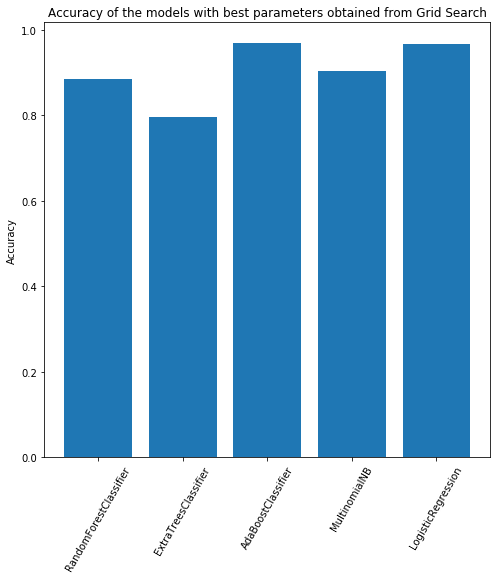

In [256]:
grid_dict = {0: 'RandomForestClassifier', 1: 'ExtraTreesClassifier', 
        2: 'AdaBoostClassifier', 3: 'MultinomialNB', 
        4: 'LogisticRegression'}

objects = ('RandomForestClassifier', 'ExtraTreesClassifier', 'AdaBoostClassifier', 'MultinomialNB', 'LogisticRegression')
y_pos = np.arange(len(objects))
performance = [0.885,0.795,0.969,0.904,0.966]
plt.rcParams['figure.figsize']=[8,8] 
plt.bar(y_pos, performance, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.xticks(rotation=60)
plt.ylabel('Accuracy')
plt.title('Accuracy of the models with best parameters obtained from Grid Search')
 
plt.show()

In [ ]:
best_gs = joblib.load('best_gs_pipeline.pkl')

In [36]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [208]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [190]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [225]:
from sklearn.metrics import classification_report

# Score the results
###print result
print("Best score: %0.3f" % best_gs.best_score_)

report(best_gs.grid_scores_)
 
print('-----grid search end------------')

print ('on all train set')
scores = cross_val_score(best_gs.best_estimator_, X_train, y_train,scoring='accuracy')
print (scores.mean(),scores)

print ('on test set')
scores = cross_val_score(best_gs.best_estimator_, X_test, y_test,scoring='accuracy')
print (scores.mean(),scores)

Best score: 0.972
Model with rank: 1
Mean validation score: 0.972 (std: 0.003)
Parameters: {'classifier__learning_rate': 0.6, 'classifier__n_estimators': 15, 'classifier__random_state': 42, 'features__text__tfidf__max_df': 0.8, 'features__text__tfidf__ngram_range': (1, 2), 'features__text__tfidf__use_idf': False}

Model with rank: 2
Mean validation score: 0.972 (std: 0.003)
Parameters: {'classifier__learning_rate': 0.6, 'classifier__n_estimators': 15, 'classifier__random_state': 42, 'features__text__tfidf__max_df': 0.9, 'features__text__tfidf__ngram_range': (1, 2), 'features__text__tfidf__use_idf': False}

Model with rank: 3
Mean validation score: 0.972 (std: 0.003)
Parameters: {'classifier__learning_rate': 0.6, 'classifier__n_estimators': 15, 'classifier__random_state': 42, 'features__text__tfidf__max_df': 0.95, 'features__text__tfidf__ngram_range': (1, 2), 'features__text__tfidf__use_idf': False}

-----grid search end------------
on all train set


C:\Users\kiran\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.9717277536089751 [0.98 0.97 0.97]
on test set
0.9638686949865409 [0.97 0.97 0.96]


In [200]:
# Score the results
y_train_pred=best_gs.best_estimator_.predict(X_train)
y_test_pred=best_gs.best_estimator_.predict(X_test)


train data
[0.99, 0.97, 0.98]
[0.98, 0.99, 0.98]


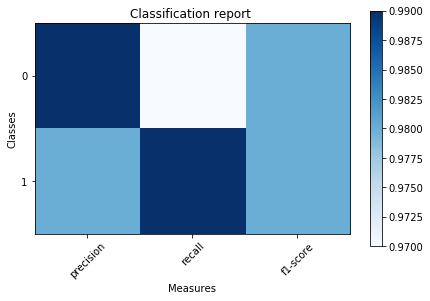

In [209]:
print('train data')
plot_classification_report(classification_report(y_train, y_train_pred ))

test data
[0.97, 0.96, 0.97]
[0.96, 0.97, 0.97]


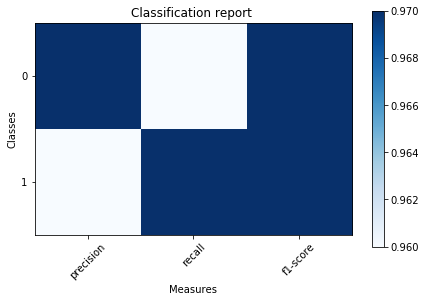

In [188]:
print('test data')
plot_classification_report(classification_report(y_test, y_test_pred ))

Confusion matrix, without normalization


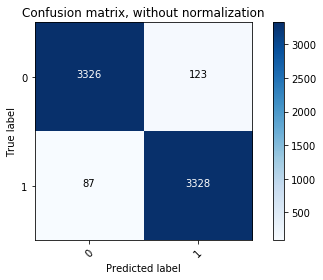

In [191]:
class_names = best_gs.best_estimator_.classes_
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')

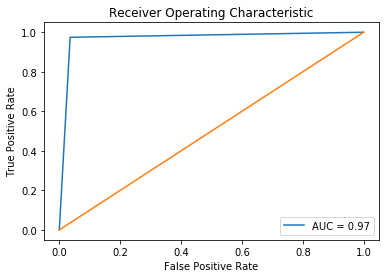

In [219]:
plt.figure(0).clf()
fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [90]:
df1=pd.read_csv('fake_or_real_news.csv')
df1 = df1.set_index('Unnamed: 0')
df1=df1.fillna(' ')
df1['total']=df1['title']+' '+df1['text']
df1 = processing(df1)
df1.label = pd.Categorical(df1.label)
y_test_1= df1.label.cat.codes
features1= [c for c in df1.columns.values if c  not in ['Unnamed: 0','title','text','label','total']]
X_test_1=df1[features1]
acc=best_gs.score(X_test_1,y_test_1)
print('The Accuracy for the data fake_or_real_news.csv when tested using AdaBoostClassifier is %.3f ' % acc)

The Accuracy for the data fake_or_real_news.csv when tested using AdaBoostClassifier is 0.454 


Confusion matrix, without normalization


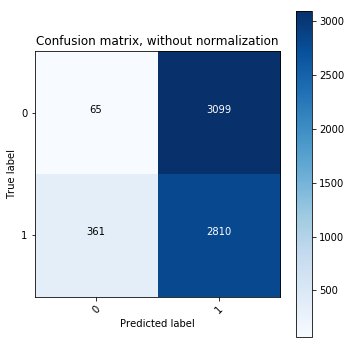

In [264]:
# class_names = best_gs.best_estimator_.classes_
y_test_pred_1=best_gs.predict(X_test_1)
cnf_matrix = confusion_matrix(y_test_1, y_test_pred_1)
np.set_printoptions(precision=2)
plt.figure()
plt.rcParams['figure.figsize']=[5,5]
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')

In [100]:
df2=pd.read_csv('data.csv')
df2=df2.fillna(' ')
df2.rename(index=str, columns={"Headline": "title", "Body": "text","Label":"label"},inplace=True)
df2['total']=df2['title']+' '+df2['text']
df2 = processing(df2)
y_test_2= df2.label
features2= [c for c in df2.columns.values if c  not in ['URLs','Unnamed: 0','title','text','label','total']]
X_test_2=df2[features2]
acc_2=best_gs.score(X_test_2,y_test_2)
print('The Accuracy for the data data.csv when tested using AdaBoostClassifier is %.3f ' % acc_2)

The Accuracy for the data data.csv when tested using AdaBoostClassifier is 0.366 


Confusion matrix, without normalization


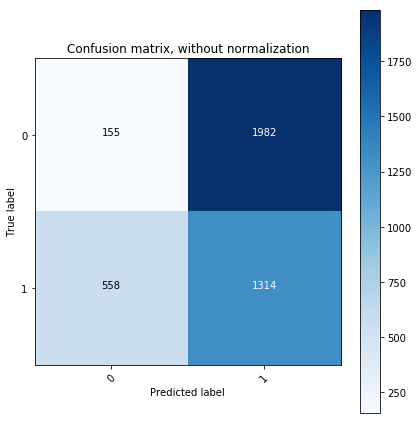

In [261]:
# class_names = best_gs.best_estimator_.classes_
y_test_pred_2=best_gs.predict(X_test_2)
cnf_matrix = confusion_matrix(y_test_2, y_test_pred_2)
np.set_printoptions(precision=2)
plt.figure()
plt.rcParams['figure.figsize']=[4,4]
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')